In [1]:
import wrf
import pandas as pd
import numpy as np
import xarray as xr
import metpy.calc as mpc
import multiprocessing as mp

from functools import partial
from metpy.units import units as mpu
from datetime import datetime

In [3]:
def calc_wbzh(tw, gh, orog):
    
    # WBZ parameter: temperature to search for 
    # 0.5 degC as in Western Region tech. attachment
    wbzparam = 0.5
        
    for i, level in enumerate(tw.level.values):
        
        if i > 0:

            level_top = tw.isel(level=i).level.values
            level_bot = tw.isel(level=i-1).level.values
            print('Searching for WBZ between %d and %d hPa'%(level_bot, level_top))

            gh_bot = gh.isel(level=i)
            gh_top = gh.isel(level=i-1)

            tw_bot = tw.isel(level=i)
            tw_top = tw.isel(level=i-1)

            # Linear interpolation of wbz height to use when/if it is between these two levels
            interp_wbzh = gh_bot + ((wbzparam - tw_bot)*((gh_top - gh_bot)/(tw_top - tw_bot)))

            if i == 1:
                # First iteration, establish the wbz height (wbzh) array
                # If WBZ between these two levels, use interpolated WBZH, else np.nan
                wbzh = xr.where( (tw_bot >= wbzparam) & (tw_top <= wbzparam), interp_wbzh, np.nan)

            else:
                # If does not exist:
                wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (np.isnan(wbzh)), interp_wbzh, wbzh)
            
                # If exists and wbzh subterrainian
                #wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (~np.isnan(wbzh) & (wbzh >= orog.min())), interp_wbzh, wbzh)

    # Where nans remain because entire column Tw < wbzparam, fill with 0 m AMSL
    wbzh = xr.where(np.isnan(wbzh) & (tw.max(dim='level') < wbzparam), 0, wbzh)
    
    return wbzh

In [4]:
def calc_tlayer(t, gh, orog):
    
    # Determine geopotential height relative to ground level
    # + 500 m buffer (see Alcott(?), I believe this may have been done as a bias correction)
    gh_agl = (gh - (orog + 500.0))

    # Where this is 0.0 m, set to 1.0 m
    gh_agl = xr.where(gh_agl == 0.0, 1.0, gh_agl)
    
    # If the 1000mb height is > 0, use the 1000 mb temperature to start
    # Otherwise assign t=0
    tvals = xr.where(gh_agl.sel(level=1000) > 0, t.sel(level=1000), 0)
    
    # Iterate through the vertical levels
    for i in range(t.level.size):
                
        # 'l' level
        # 'z' geopotential height
        # 'c/up/dn' current level/level above/level below
        
        # Current level
        lc = t.level.isel(level=i).values
        zc = gh_agl.isel(level=i)
        tc = t.isel(level=i)
                
        # Level above (corrected for 'wraparound' when iterating)
        up = i+1 if i+1 < t.level.size else 0
        lup = t.level.isel(level=up).values
        zup = gh_agl.isel(level=up)
        tup = t.isel(level=up)
        
        # Level below (corrected for 'wraparound' when iterating)
        ldn = t.level.isel(level=i-1).values
        zdn = gh_agl.isel(level=i-1)
        tdn = t.isel(level=i-1)
        
        # Print values for a sanity check while testing 
        # to ensure proper iteration/vertical wrap
        # print(i, lc, lup, ldn)
        
        # Where the geopotential height AGL is > 0 at this level 
        # and geopotential height AGL is < 0 at level below...
        tvals = xr.where(((zc > 0.0) & (zdn < 0.0)),
        
        # Determine a layer temperature
        (( zc / ( zc - zup ) ) * ( tup - tc ) + tc ),
        
        # Else use layer temperature already determined
        tvals)
    
    # In the strange exception case where 500 mb is below ground level
    # apply T500 as Tlayer (redundant failsafe - probably not needed)
    tlayer = xr.where(gh_agl.sel(level=500) < 0, t.sel(level=500), tvals)
        
    return tlayer

In [5]:
def calc_slr(tlayer, wbzh, orog):
    
    # Tunable transition layer parameters (m)
    all_snow_buffer = 0
    transition_layer = 200
    
    # Extend the snow level below the wet bulb zero parameter height if set
    snow_level = wbzh - all_snow_buffer
    snow_level = xr.where(snow_level < 0., 0., snow_level)

    # Curve fit to Alcott and Steenburgh (2010) SMLR results
    init_slr = xr.where(tlayer < 0., 5. - tlayer, 5.)
    init_slr = xr.where(tlayer < -15., 20. + (tlayer + 15.), init_slr)
    init_slr = xr.where(tlayer < -20., 15., init_slr)

    # Keep the initial SLR calculations above the snow level
    slr = xr.where(orog >= snow_level, init_slr, 0.)

    # Linear attenuation of the SLR in the transition layer
    slr = xr.where(
        ((orog < snow_level) & (orog > (snow_level - transition_layer))),
        (init_slr * (orog - (snow_level - transition_layer)) / transition_layer), slr)

    return slr

In [6]:
def wetbulb(ti, pres, tkel, qv, units):
    return wrf.wetbulb(pres.sel(time=ti), tkel.sel(time=ti), qv.sel(time=ti), units)

In [14]:
data = xr.open_dataset('./CLNX_12h_delay12_extract_gfs_ISO.nc').load()
data = data[['t', 'gh', 'r']].isel(level=slice(20, 33))
# data = data.sel(time=slice(datetime(2020, 1, 1, 0), datetime(2020, 1, 15, 12)))
data

<xarray.Dataset>
Dimensions:    (level: 13, time: 10823)
Coordinates:
  * level      (level) int64 500 550 600 650 700 750 ... 900 925 950 975 1000
    latitude   float64 40.5
    longitude  float64 -111.8
  * time       (time) datetime64[ns] 2015-01-15T15:00:00 ... 2020-06-01T12:00:00
    init       (time) datetime64[ns] 2015-01-15 ... 2020-05-31T12:00:00
    valid      (time) datetime64[ns] 2015-01-16 ... 2020-06-01T12:00:00
Data variables:
    t          (time, level) float32 256.5 262.2 267.0 ... 300.7364 302.15536
    gh         (time, level) float32 5760.2974 5036.428 ... 329.26428 113.914345
    r          (time, level) float32 18.1 14.7 12.8 12.3 ... 20.0 20.0 20.0 20.0

In [15]:
orog = xr.open_dataset('./gfs_fv3_orog.nc').sel(latitude=data.latitude, longitude=data.longitude+360)
orog = orog['orog'].values
orog = xr.DataArray(np.full(data.time.shape, fill_value=orog), dims='time')
orog['time'] = data.time
data['orog'] = orog

In [16]:
# There is no need for a hi resolution wet bulb, the difference
# in order of calculate, downscale is negligible!
print('Calculating Tw...')

# Broadcast pressure levels to the dimensions of the data
p = data.level
_p = np.ones(data.t.shape)
_p = np.array([_p[:, i]*p[i].values
    for i in range(p.size)]).transpose(1, 0)
p = data.t.copy().rename('p')
p.values = _p

# Calculate the mixing ratio
qv = data.t.copy().rename('qv')

qv.values = np.array(mpc.mixing_ratio_from_relative_humidity(
    data.r.values/100, (data.t.values-273.15)*mpu.degC, p.values*mpu.millibar))

# Repair the dimensions after metpy messes with them
qv['time'] = data.time
qv['level'] = data.level
qv['lat'] = data.latitude
qv['lon'] = data.longitude

wetbulb_mp = partial(wetbulb, pres=p*100, tkel=data.t, qv=qv, units='degC')

tw = [wetbulb_mp(ti) for ti in data.time.values]
tw = xr.concat(tw, dim='time')

# Repair the dimensions after wrf messes with them
tw['time'] = data.time
tw['level'] = data.level
tw['lat'] = data.latitude
tw['lon'] = data.longitude

data['tw'] = tw
print('Done')

data['tw']

Calculating Tw...
Done


<xarray.DataArray 'tw' (time: 10823, level: 13)>
array([[253.25261235, 257.75313515, 261.42205459, ..., 275.05595178,
        276.30387606, 277.46444428],
       [253.31904395, 257.78292798, 261.38994974, ..., 279.34553482,
        280.67903348, 282.0134718 ],
       [253.16728033, 257.54835888, 261.19114297, ..., 281.39665748,
        282.80333795, 284.02767305],
       ...,
       [259.75154495, 264.59316237, 268.78210099, ..., 287.22520877,
        288.25903234, 289.29264966],
       [258.92024866, 262.9377707 , 267.47031611, ..., 286.28628521,
        287.37456807, 288.37720723],
       [258.82469879, 262.80622617, 266.78624415, ..., 285.92010066,
        287.00090131, 288.05061877]])
Coordinates:
  * level      (level) int64 500 550 600 650 700 750 ... 900 925 950 975 1000
    latitude   float64 40.5
    longitude  float64 -111.8
  * time       (time) datetime64[ns] 2015-01-15T15:00:00 ... 2020-06-01T12:00:00
    init       (time) datetime64[ns] 2015-01-15 ... 2020-05-31T12:00:00
    valid      (time) datetime64[ns] 2015-01-16 ... 2020-06-01T12:00:00
    lat        float64 40.5
    lon        float64 -111.8
Attributes:
    units:        K
    description:  wetbulb temperature

In [17]:
data.sel(level=data.level.values[::-1])
wbzh = calc_wbzh(data['tw']-273.15, data['gh'], data['orog'])
nn_times = wbzh[~np.isnan(wbzh)].time

data['wbzh'] = wbzh
data['wbzh']

Searching for WBZ between 500 and 550 hPa
Searching for WBZ between 550 and 600 hPa
Searching for WBZ between 600 and 650 hPa
Searching for WBZ between 650 and 700 hPa
Searching for WBZ between 700 and 750 hPa
Searching for WBZ between 750 and 800 hPa
Searching for WBZ between 800 and 850 hPa
Searching for WBZ between 850 and 900 hPa
Searching for WBZ between 900 and 925 hPa
Searching for WBZ between 925 and 950 hPa
Searching for WBZ between 950 and 975 hPa
Searching for WBZ between 975 and 1000 hPa


<xarray.DataArray 'wbzh' (time: 10823)>
array([ 942.61800913, 1610.69436775, 1934.46901735, ..., 3408.13909043,
       3335.47526093, 3282.94773547])
Coordinates:
    latitude   float64 40.5
    longitude  float64 -111.8
  * time       (time) datetime64[ns] 2015-01-15T15:00:00 ... 2020-06-01T12:00:00
    init       (time) datetime64[ns] 2015-01-15 ... 2020-05-31T12:00:00
    valid      (time) datetime64[ns] 2015-01-16 ... 2020-06-01T12:00:00
    lat        float64 40.5
    lon        float64 -111.8

In [18]:
tlayer = calc_tlayer(data['t']-273.15, data['gh'], data['orog'])
tlayer

<xarray.DataArray (time: 10823)>
array([ 8.765299,  9.066063,  8.504948, ..., 14.000893, 14.673285,
       13.010113], dtype=float32)
Coordinates:
    level      int64 500
    latitude   float64 40.5
    longitude  float64 -111.8
  * time       (time) datetime64[ns] 2015-01-15T15:00:00 ... 2020-06-01T12:00:00
    init       (time) datetime64[ns] 2015-01-15 ... 2020-05-31T12:00:00
    valid      (time) datetime64[ns] 2015-01-16 ... 2020-06-01T12:00:00
    lat        float64 40.5
    lon        float64 -111.8

In [19]:
slr = calc_slr(tlayer, wbzh, data['orog']).rename('slr')
slr

<xarray.DataArray 'slr' (time: 10823)>
array([5., 5., 5., ..., 0., 0., 0.])
Coordinates:
    latitude   float64 40.5
    longitude  float64 -111.8
  * time       (time) datetime64[ns] 2015-01-15T15:00:00 ... 2020-06-01T12:00:00
    init       (time) datetime64[ns] 2015-01-15 ... 2020-05-31T12:00:00
    valid      (time) datetime64[ns] 2015-01-16 ... 2020-06-01T12:00:00
    lat        float64 40.5
    lon        float64 -111.8
    level      int64 500

(array([3873.,  152.,  162.,  136.,  142., 2956.,  453.,  434.,  386.,
         371.,  288.,  238.,  215.,  200.,  179.,  202.,  119.,  135.,
          99.,   83.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <BarContainer object of 30 artists>)

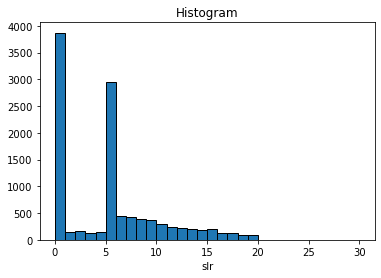

In [20]:
slr.plot.hist(bins=np.arange(0, 31, 1), edgecolor='k')

In [21]:
slr.to_netcdf('webslr.nc')